In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sympy as sp

In [2]:
from IPython.display import Math, display

In [3]:
from compute_pam import compute_combo_tensor_pam, AlphaCalc
from example_graphs import make_tree
from utils import nice_tree_plot

In [4]:
def show_math(x):
    display(Math(sp.latex(x)))

In [5]:
g = make_tree([3,3])

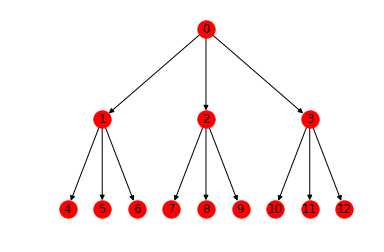

In [6]:
nice_tree_plot(g)

In [7]:
alpha_dict = dict()
for n in g.nodes():
    if g.out_degree(n) > 0:
        nbrs = list(g.neighbors(n))
        alpha_dict[n] = np.array([sp.symbols('a_{}_{}'.format(n, x)) for x in nbrs], dtype='object')
alpha = AlphaCalc.create(alpha_dict)
alpha.values

{0: array([a_0_1, a_0_2, a_0_3], dtype=object),
 1: array([a_1_4, a_1_5, a_1_6], dtype=object),
 2: array([a_2_7, a_2_8, a_2_9], dtype=object),
 3: array([a_3_10, a_3_11, a_3_12], dtype=object)}

In [8]:
R, leaf_paths = compute_combo_tensor_pam(g, alpha=alpha, ndarray_kwargs={"dtype": "object"}, return_leaf_paths=True)
R.shape

(9, 9)

In [9]:
leaf_to_index = {p[-1]: i for i, p in enumerate(leaf_paths)}
leaf_to_index

{4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7, 12: 8}

In [10]:
def R_leaf(L1, L2, R, leaf_to_index):
    i1 = leaf_to_index[L1]
    i2 = leaf_to_index[L2]
    return R[i1, i2]

In [11]:
def RL(L1, L2):
    global leaf_to_index, R
    return R_leaf(L1, L2, R, leaf_to_index)

In [12]:
show_math(RL(4,4)/RL(5,5))

<IPython.core.display.Math object>

In [13]:
show_math(RL(4,5))

<IPython.core.display.Math object>

In [14]:
show_math(RL(4,4))

<IPython.core.display.Math object>

In [15]:
sums = [x.simplify() for x in np.sum(R, axis=0)]
show_math(sums)

<IPython.core.display.Math object>

In [16]:
np.sum(sums).simplify()

1

In [17]:
show_math((RL(4,5) / RL(4,4)).simplify())

<IPython.core.display.Math object>

In [18]:
show_math((RL(4,5) / RL(5,5)).simplify())

<IPython.core.display.Math object>

In [19]:
show_math((RL(4,6) / RL(6,6)).simplify())

<IPython.core.display.Math object>

In [20]:
show_math((RL(4,6) / RL(4,4)).simplify())

<IPython.core.display.Math object>

In [21]:
def Ra(a,b):
    return sp.Symbol("R_{}_{}".format(a,b))

In [22]:
show_math(sp.Eq(
    (RL(4,6) / RL(4,4)).simplify(),
    Ra(4,6) / Ra(4,4)
))

<IPython.core.display.Math object>

In [23]:
eqs = []
for cluster in [[4,5,6], [7,8,9], [10,11,12]]:
    for n in cluster:
        for m in cluster:
            if m <= n:
                continue
            eqs.append(sp.Eq(
                (RL(m,n) / RL(m,m)).simplify(),
                Ra(m,n) / Ra(m,m)
            ))

In [24]:
show_math(eqs)

<IPython.core.display.Math object>

In [25]:
show_math(sp.solve(eqs, sp.symbols("a_1_4, a_1_5, a_1_6, a_2_7, a_2_8, a_2_9, a_3_10, a_3_11, a_3_12")))

<IPython.core.display.Math object>

In [26]:
def cross_multiply(eqn):
    lhs, rhs = eqn.args
    lnumer, ldenom = sp.fraction(lhs)
    rnumer, rdenom = sp.fraction(rhs)
    lhs = lnumer * rdenom
    rhs = rnumer * ldenom
    return sp.Eq(lhs, rhs)

In [27]:
class Analyzer(object):
    '''grouping some functions so it's easier to have multiple analyses in the same notebook'''
    def __init__(self, g, verbose = False):
        self.g = g
        self.verbose = verbose

        alpha_dict = dict()
        for n in self.g.nodes():
            if self.g.out_degree(n) > 0:
                nbrs = list(self.g.neighbors(n))
                alpha_dict[n] = np.array([sp.symbols('a_{}_{}'.format(n, x)) for x in nbrs], dtype='object')
        self.alpha = AlphaCalc.create(alpha_dict)

        self.R, self.leaf_paths = compute_combo_tensor_pam(
            self.g, alpha=self.alpha, ndarray_kwargs={"dtype": "object"}, return_leaf_paths=True)

        self.leaf_to_index = {p[-1]: i for i, p in enumerate(self.leaf_paths)}
        
    def RL(self, L1, L2):
        return R_leaf(L1, L2, self.R, self.leaf_to_index)
    
    def get_first_leaf(self, n):
        nbrs = list(self.g.neighbors(n))
        if len(nbrs) == 0:
            return n
        else:
            return self.get_first_leaf(nbrs[0])

    def setup_equations(self):
        clusters = dict()
        for n in self.g.nodes():
            if self.g.out_degree(n) > 0:
                curr_cluster = []
                for m in self.g.neighbors(n):
                    curr_cluster.append(m)
                clusters[n] = curr_cluster

        eqs_by_cluster = dict()
        vars_by_cluster = dict()
        soln_by_cluster = dict()
        for parent, cluster in clusters.items():
            if self.verbose:
                print("Solving for cluster with parent = {}".format(parent))
            csize = len(cluster)
            eqs = []
            if csize == 1:
                a = sp.Symbol("a_{}_{}".format(parent, cluster[0]))
                eqs = [sp.Eq(a, 1)]
            elif csize == 2:
                m = self.get_first_leaf(cluster[0])
                n = self.get_first_leaf(cluster[1])
                eqs = [
                    cross_multiply(sp.Eq(
                        (self.RL(m,n) / self.RL(m,m)).simplify(),
                        Ra(m,n) / Ra(m,m)
                    )),
                    cross_multiply(sp.Eq(
                        (self.RL(m,n) / self.RL(n,n)).simplify(),
                        Ra(m,n) / Ra(n,n)
                    )),
                ]
            else:
                for i in range(csize):
                    m = self.get_first_leaf(cluster[i])
                    n = self.get_first_leaf(cluster[(i + 1) % csize])
                    eqs.append(cross_multiply(sp.Eq(
                        (self.RL(m,n) / self.RL(m,m)).simplify(),
                        Ra(m,n) / Ra(m,m)
                    )))
            eqs_by_cluster[parent] = eqs
            v = [sp.symbols("a_{}_{}".format(parent, n)) for n in cluster]
            vars_by_cluster[parent] = v
        
        self.clusters = clusters
        self.eqs_by_cluster = eqs_by_cluster
        self.vars_by_cluster = vars_by_cluster

    def solve(self):
        self.setup_equations()
        
        self.soln_by_cluster = dict()
        self.solution = dict()

        for c in self.eqs_by_cluster:
            eqs = self.eqs_by_cluster[c]
            v = self.vars_by_cluster[c]
            self.soln_by_cluster[c] = sp.solve(eqs, v)
        
        for k, v in self.soln_by_cluster.items():
            self.solution.update(v)

In [28]:
g2 = make_tree([2,4])

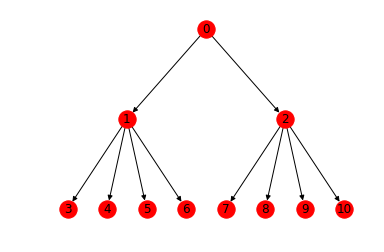

In [29]:
nice_tree_plot(g2)

In [30]:
analyzer = Analyzer(g2)

In [31]:
show_math(analyzer.RL(3,3) / analyzer.RL(3,7))

<IPython.core.display.Math object>

In [32]:
show_math(analyzer.RL(3,3) / analyzer.RL(3,4))

<IPython.core.display.Math object>

In [33]:
analyzer.solve()
show_math(analyzer.solution)

<IPython.core.display.Math object>

In [34]:
e = analyzer.eqs_by_cluster[0][0].args[0]
e

R_3_3*a_0_2*a_2_7*(a_1_3 + a_1_4 + a_1_5 + a_1_6 + 1)

In [35]:
sp.srepr(e)

"Mul(Symbol('R_3_3'), Symbol('a_0_2'), Symbol('a_2_7'), Add(Symbol('a_1_3'), Symbol('a_1_4'), Symbol('a_1_5'), Symbol('a_1_6'), Integer(1)))"

In [36]:
def pprint(e):
    if hasattr(e, "args") and e.args:
        nodes = [pprint(x) for x in e.args]
        return e.__class__.__name__ + "\n" + sp.printing.tree.pprint_nodes(nodes)
    else:
        return " " + str(e)

In [37]:
print(pprint(e))

Mul
+- R_3_3
+- a_0_2
+- a_2_7
+-Add
  +- 1
  +- a_1_3
  +- a_1_4
  +- a_1_5
  +- a_1_6



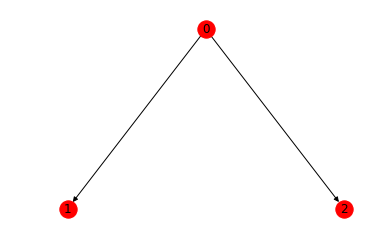

In [38]:
g3 = make_tree([2])
nice_tree_plot(g3)

In [39]:
analyzer = Analyzer(g3)

In [40]:
analyzer.solve()
show_math(analyzer.solution)

<IPython.core.display.Math object>

In [41]:
show_math(analyzer.eqs_by_cluster)

<IPython.core.display.Math object>

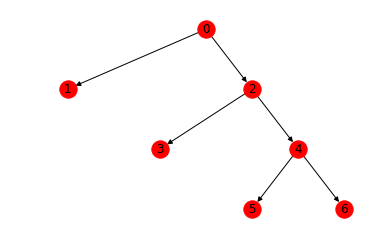

In [42]:
g4 = nx.DiGraph([(2*i, 2*i + 2) for i in range(3)] + [(2*i, 2*i + 1) for i in range(3)])
g4.graph["root"] = 0
nice_tree_plot(g4)

In [43]:
analyzer = Analyzer(g4)

In [44]:
analyzer.solve()
show_math(analyzer.solution)

<IPython.core.display.Math object>

In [45]:
show_math(analyzer.RL(1,1))
show_math(analyzer.RL(3,3))
show_math(analyzer.RL(5,5))
print("*"*20)
show_math(analyzer.RL(1,5))
show_math(analyzer.RL(3,5))
show_math(analyzer.RL(5,6))
print("*"*20)
print("RATIO:")
show_math(Ra(1,5) / Ra(5,5))
show_math(analyzer.RL(1,5) / analyzer.RL(5,5))
print("RATIO:")
show_math(Ra(3,5) / Ra(5,5))
show_math(analyzer.RL(3,5) / analyzer.RL(5,5))
print("RATIO:")
show_math(Ra(5,6) / Ra(5,5))
show_math(analyzer.RL(5,6) / analyzer.RL(5,5))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

********************


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

********************
RATIO:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

RATIO:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

RATIO:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

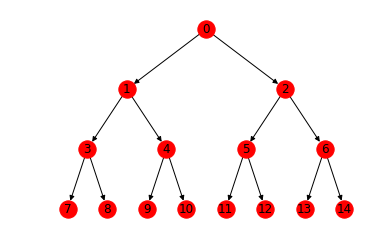

In [46]:
g5 = make_tree([2,2,2])
nice_tree_plot(g5)

In [47]:
analyzer = Analyzer(g5)

In [48]:
indices = [7, 8, 9, 11]

for j in indices:
    i = indices[0]
    show_math(sp.Eq(Ra(i,j), analyzer.RL(i,j)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [49]:
for j in indices[1:]:
    i = indices[0]
    show_math(sp.Eq(Ra(i,j) / Ra(i,i), analyzer.RL(i,j) / analyzer.RL(i,i)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [50]:
show_math(sp.Eq(Ra(8,8) / Ra(7,7), analyzer.RL(8,8) / analyzer.RL(7,7)))

<IPython.core.display.Math object>

## Analyzing single-layer trees

In [51]:
def expand_numer(x):
    a, b = sp.fraction(x)
    return a.expand() / b

for k in range(2, 5+1):
    print("#" * 20)
    print("k = {}".format(k))
    g = make_tree([k])
    analyzer = Analyzer(g)
    analyzer.solve()
    for e in analyzer.eqs_by_cluster[0]:
        show_math(e)
    show_math(analyzer.solution)
    #show_math({k: expand_numer(v) for k, v in analyzer.solution.items()})

####################
k = 2


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

####################
k = 3


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

####################
k = 4


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

####################
k = 5


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [52]:
def alphas_from_R_lists(R_star_sames, R_star_nexts):
    Rs = R_star_sames
    Rn = R_star_nexts
    num_alphas = len(Rs)
    
    denom_prod_1 = 1
    denom_prod_2 = 1
    for i in range(num_alphas):
        denom_prod_1 *= Rs[i]
        denom_prod_2 *= Rn[i]
    denom = denom_prod_1 - denom_prod_2
    
    alphas = []
    for i in range(num_alphas):
        numer = 0
        for n in range(num_alphas):
            curr_term = 1
            for m in range(num_alphas):
                offset = (i + m) % num_alphas
                if m < n:
                    curr_term *= Rs[offset]
                else:
                    curr_term *= Rn[offset]
            numer += curr_term
        alphas.append(numer / denom)

    return alphas

In [53]:
show_math(alphas_from_R_lists(
#     sp.symbols("R_1_1, R_2_2"),
#     sp.symbols("R_1_2, R_1_2")))
    sp.symbols("R_1_1, R_2_2, R_3_3"),
    sp.symbols("R_1_2, R_2_3, R_3_1")))

<IPython.core.display.Math object>

## Extract alphas

In [54]:
class AlphaExtract(object):
    def __init__(self, g, R, leaf_to_index = None):
        self.g = g
        self.R = R
        self.init_leaf_to_index(leaf_to_index)

    def init_leaf_to_index(self, leaf_to_index):
        g = None
        del g
        
        if leaf_to_index is not None:
            self.leaf_to_index = leaf_to_index
        else:
            def helper(n, leaves):
                if self.g.out_degree(n) == 0:
                    leaves.append(n)
                for nbr in self.g.neighbors(n):
                    helper(nbr, leaves)
            leaves = []
            helper(self.g.graph['root'], leaves)
            self.leaf_to_index = {n: i for i, n in enumerate(leaves)}

    def extract(self):
        tree = g = R = nbr = nbrs = None
        del tree, g, R, nbr, nbrs

        data = {x: dict() for x in self.g.nodes()}
        
        def pass1(node, parent, sibling_offset):
            data[node]["parent"] = parent
            if parent is not None:
                siblings = list(self.g.neighbors(parent))
            else:
                siblings = []
            data[node]["siblings"] = siblings
            data[node]["sibling_offset"] = sibling_offset

            children = list(self.g.neighbors(node))
            for i, child in enumerate(children):
                pass1(node = child, parent = node, sibling_offset = i)

            if len(children) == 0:
                data[node]["representative"] = node
                data[node]["is_leaf"] = True
            else:
                data[node]["representative"] = data[children[0]]["representative"]
                data[node]["is_leaf"] = False

        def pass2(node):
            for child in self.g.neighbors(node):
                pass2(child)
            
            if data[node]["parent"] is not None:
                rep = data[node]["representative"]
                i = self.leaf_to_index[rep]

                siblings = data[node]["siblings"]
                sibling_offset = data[node]["sibling_offset"]
                next_sib = siblings[(sibling_offset + 1) % len(siblings)]
                next_rep = data[next_sib]["representative"]
                j = self.leaf_to_index[next_rep]

                data[node]["next_sibling"] = next_sib
                data[node]["rep_leaf_index"] = i
                data[node]["rep_leaf_index_next_sib"] = j

        def pass3(node):
            children = list(self.g.neighbors(node))
            
            for child in children:
                pass3(child)

            if len(children) == 0:
                # Base case: node is a leaf
                data[node]["f0"] = 1
                data[node]["f1"] = 1
                return

            R_star_sames = []
            R_star_nexts = []

            for child in children:
                if "f0" not in data[child]:
                    grandchildren = list(self.g.neighbors(child))
                    gc_alpha = [data[x]["alpha"] for x in grandchildren]
                    gc_f0 = [data[x]["f0"] for x in grandchildren]
                    gc_f1 = [data[x]["f1"] for x in grandchildren]
                    data[child]["f0"] = gc_f1[0] * gc_alpha[0] / sum(gc_alpha)
                    data[child]["f1"] = gc_f0[0] * (1 + gc_alpha[0]) / (1 + sum(gc_alpha))

            for child in children:
                next_sib = data[child]["next_sibling"]
                i = data[child]["rep_leaf_index"]
                j = data[child]["rep_leaf_index_next_sib"]
                ia, ja = min(i, j), max(i, j)
                R_star_sames.append(self.R[i, i])
                R_star_nexts.append(self.R[ia, ja] * data[next_sib]["f1"] / data[child]["f0"])

            alphas = alphas_from_R_lists(R_star_sames, R_star_nexts)

            for i, child in enumerate(children):
                data[child]["alpha"] = alphas[i]
            
        root = self.g.graph["root"]
        pass1(root, parent=None, sibling_offset=None)
        pass2(root)
        pass3(root)

        self.data = data
    
        alphas = {node: data[node]["alpha"] for node in self.g.nodes() if data[node]["parent"] is not None}
        # return data
        return alphas

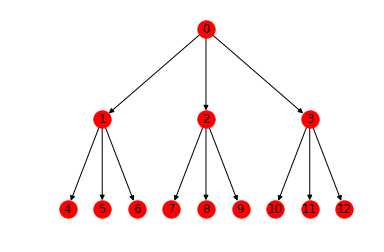

In [55]:
tree = make_tree([3,3])
nice_tree_plot(tree)
example_R = compute_combo_tensor_pam(tree)
#example_R = Analyzer(tree).R

In [56]:
ae = AlphaExtract(tree, example_R)
ae.extract()

{1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0}

In [57]:
R3 = compute_combo_tensor_pam(g3)
ae = AlphaExtract(g3, R3)
sol_alphas = ae.extract()
sol_alphas

{1: 1.0, 2: 1.0}

1 alpha = a_0_1 f0 = 1 f1 = 1
2 alpha = a_0_2 f0 = (a_2_3 + a_2_4 + 1)/(a_2_3 + 1) f1 = a_2_3/(a_2_3 + a_2_4)
3 alpha = a_2_3 f0 = 1 f1 = 1
4 alpha = a_2_4 f0 = 1 f1 = 1


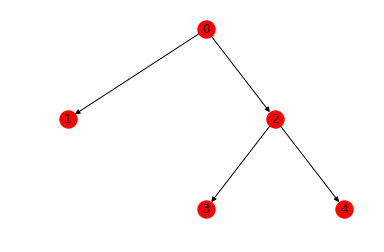

In [58]:
g = nx.DiGraph([[0,1], [0,2], [2,3], [2,4]])
g.graph["root"] = 0
nice_tree_plot(g)
ae = AlphaExtract(g, Analyzer(g).R)
sol_alphas_sym = ae.extract()
for k in [1,2,3,4]:
    print(k,
        "alpha =", sp.simplify(sol_alphas_sym[k]),
        "f0 =", sp.simplify(ae.data[k]["f0"]),
        "f1 =", sp.simplify(ae.data[k]["f1"]),
    )

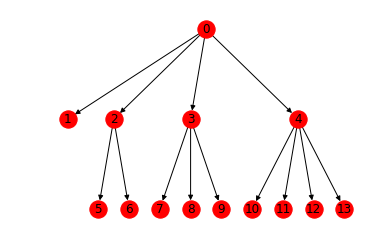

In [59]:
tree = nx.DiGraph()
tree.graph["root"] = 0
tree.add_edges_from([
    (0,1),
    (0,2),
    (0,3),
    (0,4),
    (2,5),
    (2,6),
    (3,7),
    (3,8),
    (3,9),
    (4,10),
    (4,11),
    (4,12),
    (4,13)
])
nice_tree_plot(tree)

In [60]:
analyzer = Analyzer(tree)
analyzer.setup_equations()

In [61]:
from compute_pam import IndividualNodeAlphaCalc

In [62]:
np.random.seed(1)
alpha_dict_planted = dict()
for n in tree.nodes():
    if n == 0:
        continue
    alpha_dict_planted[n] = np.random.uniform(0.5, 1.0)

R = compute_combo_tensor_pam(tree, alpha = IndividualNodeAlphaCalc(tree, alpha_dict_planted))

In [63]:
alpha_dict_planted

{1: 0.7085110023512871,
 2: 0.860162246721079,
 3: 0.5000571874086724,
 4: 0.6511662863159199,
 5: 0.5733779454085566,
 6: 0.5461692973843989,
 7: 0.5931301056888354,
 8: 0.6727803635215239,
 9: 0.698383737115335,
 10: 0.7694083670016785,
 11: 0.7095972572016473,
 12: 0.8426097501983798,
 13: 0.6022261248657588}

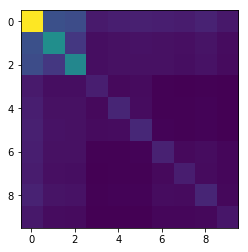

In [64]:
plt.imshow(R);

In [65]:
ae = AlphaExtract(tree, R)
sol_alphas = ae.extract()

In [66]:
sol_alphas

{1: 0.7085110023512871,
 2: 0.8601622467210789,
 3: 0.5000571874086726,
 4: 0.6511662863159199,
 5: 0.5733779454085564,
 6: 0.5461692973843987,
 7: 0.5931301056888354,
 8: 0.6727803635215241,
 9: 0.698383737115335,
 10: 0.7694083670016786,
 11: 0.7095972572016473,
 12: 0.8426097501983799,
 13: 0.6022261248657587}

In [67]:
discrep = {k: np.around(np.abs(sol_alphas[k] - alpha_dict_planted[k]), decimals=10) for k in sol_alphas}
discrep

{1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0}

## Alternate method: extract alphas by minimizing discrepancy

In [68]:
from scipy.optimize import minimize

In [69]:
def alpha_min_discrep(tree, R, x0 = None):
    root = tree.graph["root"]
    node_ordering = [x for x in tree.nodes() if x != root]
    def array_to_dict(x):
        return {n: x[i] for i, n in enumerate(node_ordering)}
    def dict_to_array(x):
        return np.array([x[n] for n in node_ordering])
    def f(x):
        alpha_dict = array_to_dict(x)
        R_est = compute_combo_tensor_pam(tree, alpha = IndividualNodeAlphaCalc(tree, alpha_dict))
        return np.linalg.norm(R_est - R, ord=2)
    if x0 is None:
        x0 = np.ones(len(node_ordering))
    elif isinstance(x0, dict):
        x0 = dict_to_array(x0)
    result = minimize(f, x0 = x0)
    min_val = result["fun"]
    print("DEBUG: min_val = {}".format(min_val))
    min_x = result["x"]
    return array_to_dict(min_x)

In [70]:
alpha_min_discrep(tree, R)

DEBUG: min_val = 0.0011671068374065042


{1: 0.7029694287428783,
 2: 0.8506203557460359,
 3: 0.48728687409719335,
 4: 0.6527770646663785,
 5: 0.5626531654336598,
 6: 0.5411882075185683,
 7: 0.7113022081962058,
 8: 0.7973456064817872,
 9: 0.8292759622309654,
 10: 0.9917375164830468,
 11: 0.9089990405823174,
 12: 1.0808814007815748,
 13: 0.7614028514322713}

In [71]:
# "cheating" by starting at the correct answer
alpha_min_discrep(tree, R, x0 = alpha_dict_planted)

DEBUG: min_val = 0.0


{1: 0.7085110023512871,
 2: 0.860162246721079,
 3: 0.5000571874086724,
 4: 0.6511662863159199,
 5: 0.5733779454085566,
 6: 0.5461692973843989,
 7: 0.5931301056888354,
 8: 0.6727803635215239,
 9: 0.698383737115335,
 10: 0.7694083670016785,
 11: 0.7095972572016473,
 12: 0.8426097501983798,
 13: 0.6022261248657588}